In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchsummary import summary
from PIL import Image
import os
# Just import the following libraries.

In [3]:
# Load the minst dataset and convert it into tensors

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(28),
                                transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.ImageFolder("train/", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.ImageFolder("test/", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)
# note we dont need the labels for DCGAN, we are just generating, not classifying

In [4]:
print(trainset[0][0].shape)

torch.Size([1, 28, 28])


In [5]:
print(len(trainset))

3025


In [6]:
from torch import nn, optim
from torch.nn import functional as F

In [7]:
def weights_init(m):
  # We need this function to initialize weights, with normal initialization, so the 
  # model trains properly
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [8]:
def disc_conv(in_c, out_c, ks=4, stride=2, padding=1, bn=True, out_layer=False):
  layers = [nn.Conv2d(in_c, out_c, kernel_size=ks, stride=stride, padding=padding, bias=False)]
  if bn: layers.append(nn.BatchNorm2d(out_c))
  layers.append(nn.Sigmoid() if out_layer else nn.LeakyReLU(0.2, inplace=True))
  return nn.Sequential(*layers)

In [9]:
D = nn.Sequential(
    disc_conv(1, 32, bn=False),
    disc_conv(32, 64),
    disc_conv(64, 128, ks=3),
    disc_conv(128, 1, out_layer=True, bn=False, padding=0)
)
D
# our discriminator is a fully convolutional network, it decides wheter image is real or fake

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Sigmoid()
  )
)

In [10]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.layers = nn.Sequential(*[
                                  self.conv_block(100, 128, padding=0),
                                  self.conv_block(128, 64, stride=2, ks=3),
                                  self.conv_block(64, 32, stride=2),
                                  self.conv_block(32, 1, stride=2, bn=False, out_layer=True)
    ])
    # Our input is 100 dimensional random noise
  
  @staticmethod
  def conv_block(in_c, out_c, out_layer=False, ks=4, stride=1, padding=1, bias=False, bn=True):
    l = [nn.ConvTranspose2d(in_c, out_c, ks, stride=stride, padding=padding, bias=bias)]
    if bn: l.append(nn.BatchNorm2d(out_c))
    if out_layer: l.append(nn.Tanh())
    else: l.append(nn.ReLU(True))
    return nn.Sequential(*l)
  
  def forward(self, x):
    return self.layers(x)

In [11]:
G = Generator()
G

Generator(
  (layers): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Tanh()
    )
  )
)

In [12]:
fixed_noise = torch.rand((32, 100, 1, 1))
G.apply(weights_init)
D.apply(weights_init)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (3): Sequential(
    (0): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Sigmoid()
  )
)

In [13]:
criterion = nn.BCELoss()

In [14]:
optim_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [14]:
D = D
G = G
criterion = criterion

In [15]:
EPOCHS = 10
FAKE_LABEL = 0.0
REAL_LABEL = 1.0

In [16]:
for epoch in range(EPOCHS + 1):
  loss_d = 0.0
  loss_g = 0.0

  for i, (images, labels) in enumerate(trainloader):
    images = images
    fake_labels = torch.full((images.size(0), ), FAKE_LABEL)
    real_labels = torch.full((images.size(0), ), REAL_LABEL)

    ## Train Discriminator ##    
    D.zero_grad()

    d_real = D(images).view(-1)
    d_loss_real = criterion(d_real, real_labels)
    d_loss_real.backward()

    noise = torch.randn((images.size(0), 100, 1, 1))
    fake_images = G(noise)

    d_fake = D(fake_images.detach()).view(-1)
    d_loss_fake = criterion(d_fake, fake_labels)
    d_loss_fake.backward()

    d_loss = d_loss_real + d_loss_fake
    optim_D.step()

    ## Train Generator ##
    G.zero_grad()

    d_fake = D(fake_images).view(-1)
    g_loss = criterion(d_fake, real_labels)
    g_loss.backward()

    optim_G.step()

    if i % 100 == 0:
      print(f"Epoch [{epoch}/{EPOCHS}], Batch [{i}], LOSS_D: {d_loss}, LOSS_G: {g_loss}")


Epoch [0/10], Batch [0], LOSS_D: 1.4547573328018188, LOSS_G: 0.9587509036064148
Epoch [1/10], Batch [0], LOSS_D: 0.18917620182037354, LOSS_G: 3.1071548461914062
Epoch [2/10], Batch [0], LOSS_D: 0.16201186180114746, LOSS_G: 3.2341527938842773
Epoch [3/10], Batch [0], LOSS_D: 0.25892114639282227, LOSS_G: 2.4816179275512695
Epoch [4/10], Batch [0], LOSS_D: 0.5300347805023193, LOSS_G: 4.184812068939209
Epoch [5/10], Batch [0], LOSS_D: 0.5090351104736328, LOSS_G: 1.998051643371582
Epoch [6/10], Batch [0], LOSS_D: 0.4886518120765686, LOSS_G: 2.559831380844116
Epoch [7/10], Batch [0], LOSS_D: 0.43700575828552246, LOSS_G: 1.7811387777328491
Epoch [8/10], Batch [0], LOSS_D: 0.6466518640518188, LOSS_G: 1.4995445013046265
Epoch [9/10], Batch [0], LOSS_D: 0.6155319213867188, LOSS_G: 2.6489968299865723
Epoch [10/10], Batch [0], LOSS_D: 0.5869283676147461, LOSS_G: 2.2003493309020996


In [17]:
import numpy as np
import torchvision.utils as vutils

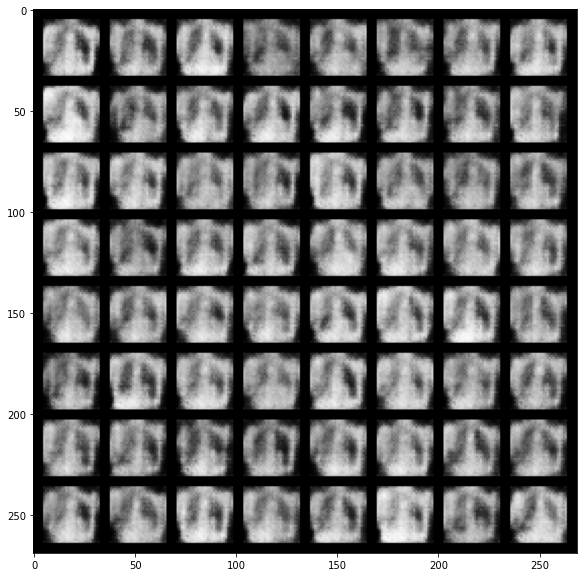

In [20]:
fig = plt.figure(figsize=(10, 10))
rand_noise = torch.rand((64, 100, 1, 1))
out = vutils.make_grid(G(rand_noise), padding=5, normalize=True)
plt.imshow(np.transpose(out.numpy(), (1, 2, 0)), cmap="gray")